# Exploring TensorFlow Low Level API
* Simple CNN using [TensorFlow Low Level API](https://www.tensorflow.org/guide/low_level_intro)
* __Naming your tensors (input/output) properly__
* Different ways to save models

## Necessary imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from mnist import mnist
import random

## Load MNIST data
* Using [MNIST data load util](https://github.com/anujonthemove/Computer-Vision-Playground/blob/master/utils/mnist.py)
* __NOTE:__ In order to run this entire pipeline, please copy the `mnist.py` file from the `utils` directory 
and put it next to this notebook.

In [2]:
obj = mnist()
X_train, y_train, X_test, y_test = obj.load_data()

# split into validation and test set from the test set alone
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, random_state=0)

Downloading:  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Downloading:  http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Downloading:  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Downloading:  http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
print('==== Printing shapes of data ===')
print()
print('Train data:      ', X_train.shape, y_train.shape)
print('Test data:       ', X_test.shape, y_test.shape)
print('Validation data: ', X_validation.shape, y_validation.shape)

==== Printing shapes of data ===

Train data:       (60000, 32, 32, 1) (60000,)
Test data:        (7500, 32, 32, 1) (7500,)
Validation data:  (2500, 32, 32, 1) (2500,)


## Neural Network class for MNIST 

In [4]:
class MNISTClassification(object):
    def __init__(self, X_train, y_train, X_test, y_test, X_validation, y_validation, batch_size=128, 
                 epochs=10, model_dir = './models/mnist/lenet'):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_validation = X_validation
        self.y_validation = y_validation
        
        self.batch_size = batch_size
        self.epochs = epochs
        
        self.x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name="input")
        self.y = tf.placeholder(tf.int32, shape=[None])
        self.one_hot_y = tf.one_hot(self.y, 10)
    
        self.logits = self.LeNet5(self.x)
        self.y_pred = tf.nn.softmax(self.logits, name="output")
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.one_hot_y, 
                                                                                 logits=self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        self.training_op = self.optimizer.minimize(self.loss_op)
        self.correct_pred_op = tf.equal(tf.math.argmax(self.logits, 1), tf.math.argmax(self.one_hot_y, 1))
        self.accuracy_op = tf.reduce_mean(tf.cast(self.correct_pred_op, tf.float32))
        
        config = tf.ConfigProto(device_count={'GPU':1, 'CPU':2})
        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.75
        
        self.sess = tf.Session(config=config)
        self.sess.run(tf.global_variables_initializer())
        
        self.model_dir = model_dir
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)

        
    def LeNet5(self, x):
    
        ################   conv > relu > pool Block ####################
        '''
        convolution layer
        Input: 32x32x1
        Output: 28x28x6 - because we are taking 5x5 kernel

        W' = [(W-F + 2P)/S]+1
        where, 
        W' = dimension of output volume
        W = dimension of input volume
        F = kernel size
        P = padding 
        S = stride 

        kernel size: 5x5x1, number of kernels: 6
        '''
        conv1_w = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 6], mean=0, stddev=0.1))
        conv1_b = tf.Variable(tf.zeros(6)) 
        conv1 = tf.nn.conv2d(x, conv1_w, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

        '''
        relu 
        size remains same
        '''
        conv1 = tf.nn.relu(conv1)

        '''
        pooling
        Input: 28x28x6
        Output: 14x14x6
        '''
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


        '''
        convolution layer
        Input: 14x14x6
        Ouput: 10x10x16
        '''
        conv2_w = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=0, stddev=0.1))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2 = tf.nn.conv2d(pool1, conv2_w, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

        '''
        relu 
        size remains same
        '''
        conv2 = tf.nn.relu(conv2)


        '''
        pooling
        Input: 10x10x16
        Ouput: 5x5x16
        '''
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


        ############################################################################

        ######################## reshape/flatten/fully connected layers ############

        '''
        flatten & fully connected layers
        Input: 5x5x16
        Intermediate (after reshape/flatten): 400 (5*5*16)
        Output: 120
        '''
        fc1 = tf.reshape(pool2, [-1, 5*5*16])
        fc1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=0, stddev=0.1))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1 = tf.matmul(fc1, fc1_w) + fc1_b

        '''
        activation
        '''
        fc1 = tf.nn.relu(fc1)


        '''
        fully connected layer
        '''
        fc2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=0, stddev=0.1))
        fc2_b = tf.Variable(tf.zeros(84))
        fc2 = tf.matmul(fc1, fc2_w) + fc2_b


        '''
        activation
        '''

        fc2 = tf.nn.relu(fc2)

        ####################################################################


        '''
        fully connected layer
        '''

        fc3_w = tf.Variable(tf.truncated_normal(shape=(84, 10), mean=0, stddev=0.1))
        fc3_b = tf.Variable(tf.zeros(10))

        logits = tf.matmul(fc2, fc3_w) + fc3_b

        return logits
    
    def evaluate(self, X_tmp, y_tmp):
        BATCH_SIZE = self.batch_size
        num_examples = len(X_tmp)

        total_accuracy = 0
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_tmp[offset:offset+BATCH_SIZE], y_tmp[offset:offset+BATCH_SIZE]
            accuracy = self.sess.run(self.accuracy_op, feed_dict={self.x:batch_x, self.y:batch_y})
            total_accuracy += (accuracy*len(batch_x))

        return total_accuracy/num_examples

    def release_session(self):
        print('Releasing session ...')
        print()
        tf.reset_default_graph()
        self.sess.close()
        print('Done!')
        
        
    def train(self, save_model=False):
        BATCH_SIZE = self.batch_size
        EPOCHS = self.epochs
        num_examples = len(self.X_train)
    
        print('Training on dataset size: ', num_examples)
        print()

        for epoch in range(EPOCHS):
            print('===> Epoch: {}'.format(epoch+1))
            x_tr, y_tr = shuffle(self.X_train, self.y_train)

            for offset in range(0, num_examples, BATCH_SIZE):
                batch_x, batch_y = x_tr[offset:offset + BATCH_SIZE], y_tr[offset:offset + BATCH_SIZE]
                self.sess.run(self.training_op, feed_dict={self.x:batch_x, self.y:batch_y})

            validaion_accuracy = self.evaluate(self.X_validation, self.y_validation)

            print('===> Validation Accuracy: {:0.3f}'.format(validaion_accuracy))
            print()
        test_accuracy = self.evaluate(self.X_test, self.y_test)
        print('===> Test Accuracy: {:0.3f}'.format(test_accuracy))
        
        
    def save_model_using_saver_api(self, export_path, name, list_variables=False):
        path_to_model = os.path.join(export_path, name)
        saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)
        if list_variables:
            for i, var in enumerate(saver._var_list):
                print('Var {}: {}'.format(i, var))
        save_path = saver.save(self.sess, path_to_model+'.ckpt', global_step=self.epochs)
        tf.train.write_graph(self.sess.graph.as_graph_def(), export_path, name=name+'.pbtxt', as_text=True)
        print('saved model at: ', save_path)
    
    def save_model_using_SavedModelBuilder(self, export_path, list_nodes=False):
        builder = tf.saved_model.builder.SavedModelBuilder(export_path)
            
        # get input, output tensor names
        x = tf.get_default_graph().get_tensor_by_name("input:0")
        y = tf.get_default_graph().get_tensor_by_name("output:0")
        
        signature = tf.saved_model.predict_signature_def(
            inputs={'input': x}, outputs={'output': y}
        )
        
        # using custom tag instead of: tags=[tf.saved_model.tag_constants.SERVING]
        builder.add_meta_graph_and_variables(
            sess=self.sess, tags=['serve'], signature_def_map={'predict': signature}
        )
        
        builder.save()
        
        if list_nodes:
            print([n.name for n in tf.get_default_graph().as_graph_def().node])
            
    def save_model_using_simple_save(self, export_path):
        print('==== WARNING from TensorFlow ====')
        print()
        print('Source: https://www.tensorflow.org/api_docs/python/tf/saved_model/simple_save')
        print('Warning: THIS FUNCTION IS DEPRECATED. It will be removed in a future version.\
        Instructions for updating: This function will only be available through the v1 \
        compatibility library as tf.compat.v1.saved_model.simple_save.')
        print()
        # get input, output tensor names
        x = tf.get_default_graph().get_tensor_by_name("input:0")
        y = tf.get_default_graph().get_tensor_by_name("output:0")
        
        tf.saved_model.simple_save(self.sess, export_path, inputs={"input": x},outputs={"output": y})
            
    def predict(self, X):
        x = tf.get_default_graph().get_tensor_by_name("input:0")
        y = tf.get_default_graph().get_tensor_by_name("output:0")
        y_prediction = self.sess.run(y, feed_dict={x: X})
        y_pred_prime = np.argmax(y_prediction, axis=1)
        return y_pred_prime
    
    
    def display_nodes_and_ops(self, print_nodes=False):
        if print_nodes:
            for n in tf.get_default_graph().as_graph_def().node:
                print(n.name)
                
    def display(self, idx, X_tmp, y_tmp, title):
        if X_tmp.shape[1:] != (32, 32, 1):
                print('Invalid shape image provided')
        else:
            image = X_tmp[idx].squeeze()
            plt.figure()
            plt.imshow(image, cmap=plt.cm.gray_r)
            # plt.axis('off')
            plt.title('\n\n{}'.format(title), fontdict={'size': 16})

## Initialize

In [5]:
model = MNISTClassification(X_train, y_train, X_test, y_test, X_validation, y_validation, epochs=1)

Instructions for updating:
Colocations handled automatically by placer.


## Display image

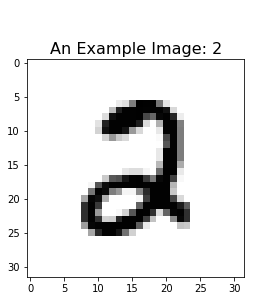

In [6]:
rando = random.randint(0,len(X_test)-1)
model.display(rando, X_test, y_test, 'An Example Image: {}'.format(y_test[rando]))

## Train model

In [7]:
model.train()

Training on dataset size:  60000

===> Epoch: 1
===> Validation Accuracy: 0.958

===> Test Accuracy: 0.955


## Print all nodes in the architecture

In [8]:
model.display_nodes_and_ops(print_nodes=False)

## Save model

### a. using tf.train.saver

In [9]:
model.save_model_using_saver_api(export_path='./models/mnist/lenet', name='lenet', list_variables=False)

saved model at:  ./models/mnist/lenet/lenet.ckpt-1


### b. using  tf.saved_model.builder.SavedModelBuilder 

In [10]:
model.save_model_using_SavedModelBuilder(export_path='./models/mnist/lenet/using_SavedModelBuilder', 
                                         list_nodes=False)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./models/mnist/lenet/using_SavedModelBuilder/saved_model.pb


### c. using  tf.saved_model.simple_save - DEPRECATED

In [11]:
model.save_model_using_simple_save(export_path='./models/mnist/lenet/using_simple_save')

==== WARNING from TensorFlow ====

Source: https://www.tensorflow.org/api_docs/python/tf/saved_model/simple_save

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./models/mnist/lenet/using_simple_save/saved_model.pb


## Release session

In [12]:
model.release_session()

Releasing session ...

Done!


## References

* https://medium.com/@lisulimowicz/tensorflow-cpus-and-gpus-configuration-9c223436d4ef
* https://github.com/tensorspace-team/tensorspace/blob/master/docs/preprocess/TensorFlow/src_py/tensorflow_create_model.py
* https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9#scrollTo=1w66ueiLlP0k
* https://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/
* https://medium.com/@jsflo.dev/saving-and-loading-a-tensorflow-model-using-the-savedmodel-api-17645576527